In [1]:
# import lib 
import matplotlib.pyplot as plt
import imutils
from imutils.object_detection import non_max_suppression
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import numpy as np
import requests
import pytesseract
import cv2

In [2]:
# function
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()
 
def decode_predictions(scores, geometry):
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []
 
	for y in range(0, numRows):
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]
 
		for x in range(0, numCols):
			if scoresData[x] < min_confidence:
				continue
 
			(offsetX, offsetY) = (x * 4.0, y * 4.0)
 
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)
 
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]
 
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)
 
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])
 
	return (rects, confidences)

In [3]:
# load model
layerNames = ["feature_fusion/Conv_7/Sigmoid", # first layer : whether region has text
              "feature_fusion/concat_3"] # extract bounding box
 
# 사전에 훈련된 EAST text detector 모델 Load
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(r"C:\Users\Refine\Desktop\Untitled Folder\EAST_text_detection\frozen_east_text_detection.pb")

width = 640
height = 640
min_confidence = 0.5
padding = 0.0

[INFO] loading EAST text detector...


In [6]:
# image load
image_path = 'X:\hdata\H02\000509\88cbbc28-13ff-4b9b-85b1-3c8efa3c50de.png'
img_array = np.fromfile(image_path, np.uint8)
image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

# input image의 size가 32의 배수여야한다.
orig_image=image.copy()
text_extract_image=image.copy()
(H,W) = image.shape[:2]

# 새로운 width와 height를 설정하고 비율을 구한다
(newW,newH) = width,height
rW=W/float(newW)
rH=H/float(newH)

# image의 size를 재설정하고 새 이미지의 dimension을 구한다
image=cv2.resize(image,(newW,newH))
(H,W) = image.shape[:2]

ValueError: embedded null character

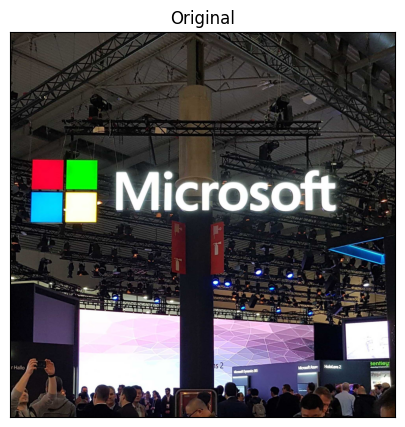

In [10]:
'''
url = 'https://user-images.githubusercontent.com/69428232/149087561-4803b3e0-bcb4-4f9f-a597-c362db24ff9c.jpg'
 
image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 
 
plt_imshow("Original", org_image)
'''

In [ ]:
plt_imshow("Original", image)

In [12]:
'''
image = org_image
# image resize
orig = image.copy()
(origH, origW) = image.shape[:2]
 
(newW, newH) = (width, height)
rW = origW / float(newW)
rH = origH / float(newH)
 
org_image = cv2.resize(image, (newW, newH))
(H, W) = org_image.shape[:2]
'''

In [13]:
# text detection
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
 
(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences) # non-maxima suppression 을 weak,overlapping bounding boxes을 없애기위해 적용해준다

In [21]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [22]:
# recognition
results = []
 
for (startX, startY, endX, endY) in boxes:
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
 
	dX = int((endX - startX) * padding)
	dY = int((endY - startY) * padding)
 
	startX = max(0, startX - dX)
	startY = max(0, startY - dY)
	endX = min(origW, endX + (dX * 2))
	endY = min(origH, endY + (dY * 2))
	# 영역 추출
	roi = orig[startY:endY, startX:endX]
 
	#config = ("-l eng --psm 4")
	text = pytesseract.image_to_string(roi, lang='kor') # text를 읽어오는 pytesseract
 
	results.append(((startX, startY, endX, endY), text))

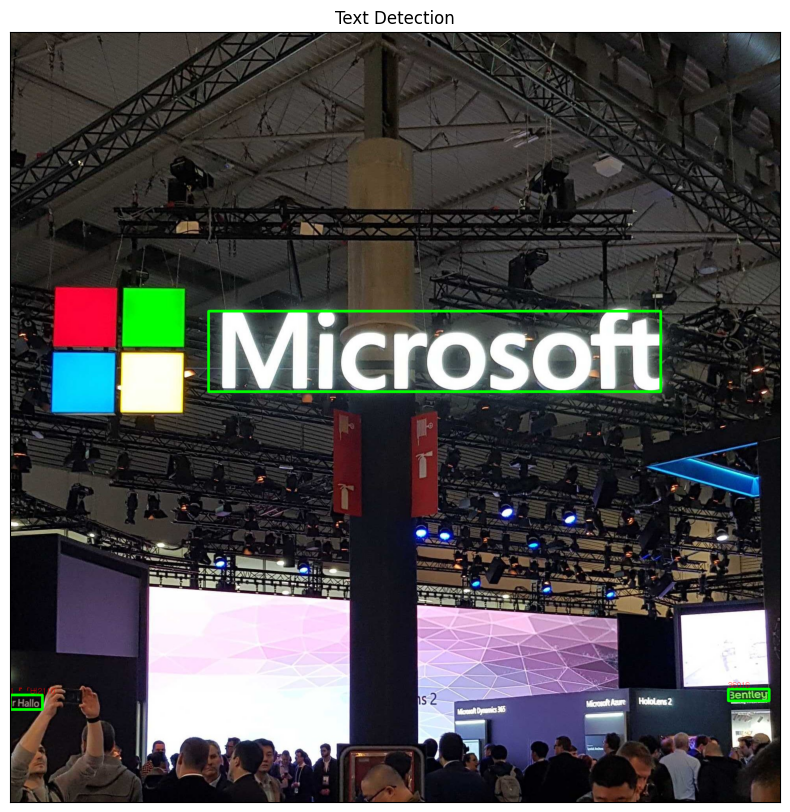

In [23]:
# result
results = sorted(results, key=lambda r:r[0][1])
 
output = orig.copy()
 
# 결과 출력
from PIL import ImageFont, ImageDraw, Image
font = ImageFont.truetype('...\gulim.ttc',20)


for ((startX, startY, endX, endY), text) in results:
    cv2.rectangle(output, (startX, startY), (endX, endY), (0, 255, 0), 5)
	#cv2.putText(output, text, (startX, startY - 20), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 5)
    # error with korean
    img_pil = Image.fromarray(output)
    draw = ImageDraw.Draw(img_pil)
    draw.text((startX, startY - 20) , text, (0,0,255), font=font)
    output = np.array(img_pil)
 
plt_imshow("Text Detection", output, figsize=(16, 10))

### 마우스를 이용하여 이미지에서 원하는 부분을 ROI로 지정

In [34]:
# image load

url = 'https://miro.medium.com/v2/resize:fit:720/format:webp/0*xwT3ud45oDM6TRFP.png'
 
image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 
image = org_image

'''
image_path = '.jpg'
img_array = np.fromfile(image_path, np.uint8)
image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
'''
x,y,w,h = cv2.selectROI('image',image,False)

if w and h:
    roi = image[y:y+h, x:x+w]
    cv2.imshow('test',roi)
    cv2.imwrite('test.jpg',roi)
# tesseract를 이용해서 ocr을 진행하도록 한다
    ocr = pytesseract.image_to_string('test.jpg',lang='kor')
    print(ocr)
    
cv2.waitKey(0)
cv2.destroyAllWindows()

인사하다 천둥 서적 감동

